In [1]:
import numpy as np 
import pandas as pd
import tmap as tm

from rdkit import Chem
from rdkit import DataStructs
from rdkit.Chem import AllChem
from rdkit.Chem import rdMolDescriptors
from rdkit.Chem.AtomPairs import Pairs
from mxfp import mxfp
from map4 import MAP4Calculator
from mhfp.encoder import MHFPEncoder
from sklearn.neighbors import NearestNeighbors

import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
import seaborn as sns
from faerun import Faerun
from drfp import DrfpEncoder

from tqdm import tqdm
tqdm.pandas()

#### Data pre-processing

Import dataset, kekulize SMILES, remove stereochemistry and remove duplicates

In [2]:
df = pd.read_csv('data/zinc_fda.csv')

df['ROMol'] = df.smiles.apply(Chem.MolFromSmiles)
df['smiles'] = df.ROMol.apply(lambda x: Chem.MolToSmiles(x, kekuleSmiles=True, isomericSmiles=False))
df = df.drop_duplicates(subset=['smiles'])

Add molecular properties (molecular weight, heavy atom count, fraction of sp3-hybridized carbons)

In [3]:
df['MW'] = df.ROMol.apply(rdMolDescriptors.CalcExactMolWt)
df['HAC'] = df.ROMol.apply(rdMolDescriptors.CalcNumHeavyAtoms)
df['FCsp3'] = df.ROMol.apply(rdMolDescriptors.CalcFractionCSP3)

#### Calculate molecular descriptors

Calculate MXFP, AP, MAP4, MHFP6, ECFP4, ECFP6, MACCS and MQN descriptors for every molecule

In [4]:
MAP4 = MAP4Calculator(dimensions=2048)
MHFP6 = MHFPEncoder(n_permutations=2048)
MXFP = mxfp.MXFPCalculator(dimensionality='2D')

In [5]:
df['MXFP'] = df.ROMol.progress_apply(MXFP.mxfp_from_mol)
df['AP'] = df.ROMol.progress_apply(Pairs.GetAtomPairFingerprintAsBitVect)
df['MAP4'] = df.ROMol.progress_apply(MAP4.calculate)
df['MHFP6'] = df.smiles.progress_apply(MHFP6.encode)
df['ECFP4'] = df.ROMol.progress_apply(lambda x: AllChem.GetMorganFingerprintAsBitVect(x, 2)) 
df['ECFP6'] = df.ROMol.progress_apply(lambda x: AllChem.GetMorganFingerprintAsBitVect(x, 3)) 
df['MACCS'] = df.ROMol.progress_apply(rdMolDescriptors.GetMACCSKeysFingerprint)
df['MQN'] = df.ROMol.progress_apply(rdMolDescriptors.MQNs_)

100%|██████████| 1215/1215 [00:00<00:00, 11743.17it/s]


#### Determine pairwise distances between every molecule

Define functions to calculate distance metrics

In [6]:
ENC = tm.Minhash(2048)

def jaccard(a, b):
    return ENC.get_distance(a, b)

def mhfp(a, b):
    return 1.0 - float(np.count_nonzero(a == b)) / float(len(a))

def manhattan(a, b):
    return sum(abs(np.array(a) - np.array(b)))

def dice(a, b):
    return 1.0 - DataStructs.DiceSimilarity(a, b)

def tanimoto(a, b):
    return 1.0 - DataStructs.FingerprintSimilarity(a, b)

Generate pairwise distances of every molecular pair for every fingerprint

In [7]:
def PairwiseDistanceList(fp_list, metric):
    distance_list = []
    for i in range(len(fp_list)):
        for j in range(len(fp_list)):
            distance_list.append(metric(fp_list[i], fp_list[j]))
    return distance_list

mxfp2d = df.MXFP.values.tolist()
ap = df.AP.values.tolist()
map4 = df.MAP4.values.tolist()
mhfp6 = df.MHFP6.values.tolist()
ecfp4 = df.ECFP4.values.tolist()
ecfp6 = df.ECFP6.values.tolist()
maccs = df.MACCS.values.tolist()
mqn = df.MQN.values.tolist()

mxfp2d_distlist = PairwiseDistanceList(mxfp2d, manhattan)
ap_distlist = PairwiseDistanceList(ap, tanimoto)
map4_distlist = PairwiseDistanceList(map4, jaccard) 
mhfp6_distlist = PairwiseDistanceList(mhfp6, mhfp) 
ecfp4_distlist = PairwiseDistanceList(ecfp4, tanimoto)
ecfp6_distlist = PairwiseDistanceList(ecfp6, tanimoto)
maccs_distlist = PairwiseDistanceList(maccs, tanimoto) 
mqn_distlist = PairwiseDistanceList(mqn, manhattan)

Normalize MXFP and MQN distances (MinMax normalization between 0 and 1)

In [8]:
def MinMax(matrix):
    return (matrix-np.min(matrix))/(np.max(matrix)-np.min(matrix))

mxfp2d_distlist = MinMax(mxfp2d_distlist)
mqn_distlist = MinMax(mqn_distlist)

#### Plot distributions of distances and ranks

Plot distributions of distances

In [9]:
df_violin = pd.DataFrame(list(zip(mxfp2d_distlist, ap_distlist, map4_distlist, mhfp6_distlist, ecfp4_distlist, ecfp6_distlist, maccs_distlist, mqn_distlist)), 
                        columns=['MXFP', 'AP', 'MAP4', 'MHFP6', 'ECFP4', 'ECFP6', 'MACCS', 'MQN'])

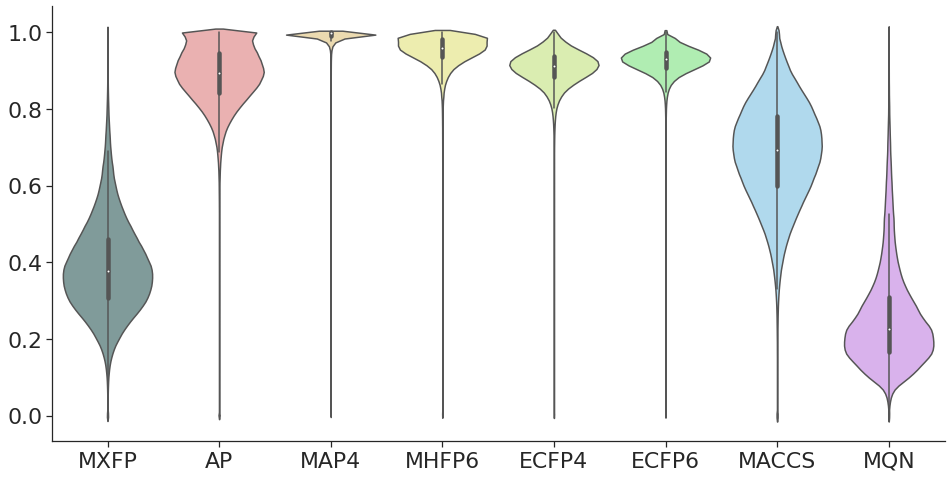

In [11]:
ax = sns.violinplot(data=df_violin, scale='count', palette=sns.color_palette(['#7B9F9E', '#F4A7A7', '#F5DEA6', '#F7F7A5', '#DEF7A7', '#A6F7A8', '#A6DDF7', '#DCA8F6']))

sns.set(rc={'figure.figsize':(16, 8)})
sns.set(font_scale=2)
sns.set_style('ticks')
sns.despine()
plt.savefig('plots/fda_approved_distance_distributions.pdf', bbox_inches='tight')

Plot heatmap of pairwise Euclidean distances between the distances

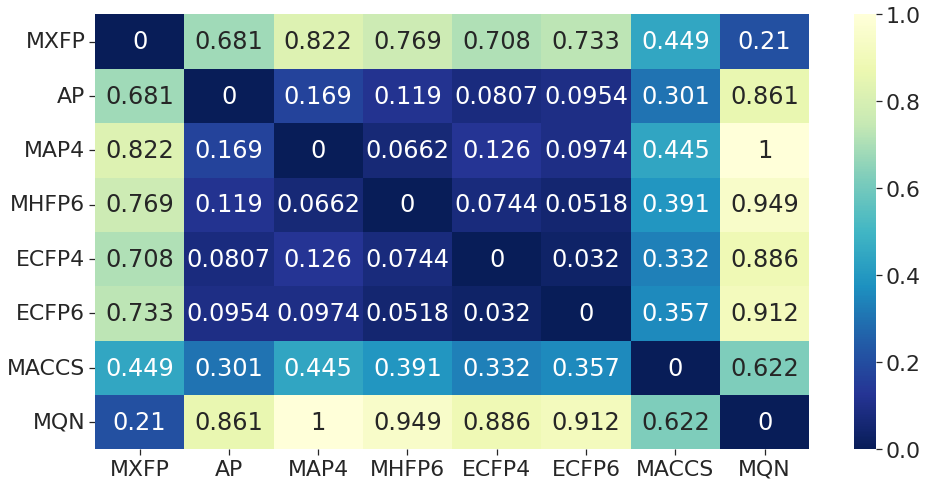

In [12]:
distance_matrices_list = [mxfp2d_distlist, ap_distlist, map4_distlist, mhfp6_distlist, ecfp4_distlist, ecfp6_distlist, maccs_distlist, mqn_distlist]
nn_distance_matrix = np.zeros((len(distance_matrices_list), len(distance_matrices_list)))

for i in range(len(distance_matrices_list)):
    for j in range(len(distance_matrices_list)):
        nn_distance_matrix[i, j] = np.linalg.norm(np.array(distance_matrices_list[i]) - np.array(distance_matrices_list[j]))

nn_distance_matrix = MinMax(nn_distance_matrix)
pairwise_matrix = pd.DataFrame(nn_distance_matrix, 
                                columns=['MXFP', 'AP', 'MAP4', 'MHFP6', 'ECFP4', 'ECFP6', 'MACCS', 'MQN'], 
                                index=['MXFP', 'AP', 'MAP4', 'MHFP6', 'ECFP4', 'ECFP6', 'MACCS', 'MQN'])

ax = sns.heatmap(pairwise_matrix, annot=True, fmt='.3g', cmap="YlGnBu_r")
plt.savefig('plots/fda_approved_euclidean_distances_heatmap.pdf', bbox_inches='tight')

Generate ranked matrices for every fingerprint. Every column (=compound) has their distances ranked from closest to farthest.

In [13]:
mxfp2d_rankmat = pd.DataFrame(np.array(mxfp2d_distlist).reshape(len(mxfp2d), len(mxfp2d)).T).rank(method='average')
ap_rankmat = pd.DataFrame(np.array(ap_distlist).reshape(len(ap), len(ap)).T).rank(method='average')
map4_rankmat = pd.DataFrame(np.array(map4_distlist).reshape(len(map4), len(map4)).T).rank(method='average')
mhfp6_rankmat = pd.DataFrame(np.array(mhfp6_distlist).reshape(len(mhfp6), len(mhfp6)).T).rank(method='average')
ecfp4_rankmat = pd.DataFrame(np.array(ecfp4_distlist).reshape(len(ecfp4), len(ecfp4)).T).rank(method='average')
ecfp6_rankmat = pd.DataFrame(np.array(ecfp6_distlist).reshape(len(ecfp6), len(ecfp6)).T).rank(method='average')
maccs_rankmat = pd.DataFrame(np.array(maccs_distlist).reshape(len(maccs), len(maccs)).T).rank(method='average')
mqn_rankmat = pd.DataFrame(np.array(mqn_distlist).reshape(len(mqn), len(mqn)).T).rank(method='average')

Plot distribution of distances

In [14]:
mxfp2d_rank_flat = mxfp2d_rankmat.to_numpy().flatten()
ap_rank_flat = ap_rankmat.to_numpy().flatten()
map4_rank_flat = map4_rankmat.to_numpy().flatten()
mhfp6_rank_flat = mhfp6_rankmat.to_numpy().flatten()
ecfp4_rank_flat = ecfp4_rankmat.to_numpy().flatten()
ecfp6_rank_flat = ecfp6_rankmat.to_numpy().flatten()
maccs_rank_flat = maccs_rankmat.to_numpy().flatten()
mqn_rank_flat = mqn_rankmat.to_numpy().flatten()

df_rank_violin = pd.DataFrame(list(zip(mxfp2d_rank_flat, ap_rank_flat, map4_rank_flat, mhfp6_rank_flat, ecfp4_rank_flat, ecfp6_rank_flat, maccs_rank_flat, mqn_rank_flat)), 
                            columns=['MXFP', 'AP', 'MAP4', 'MHFP6', 'ECFP4', 'ECFP6', 'MACCS', 'MQN'])

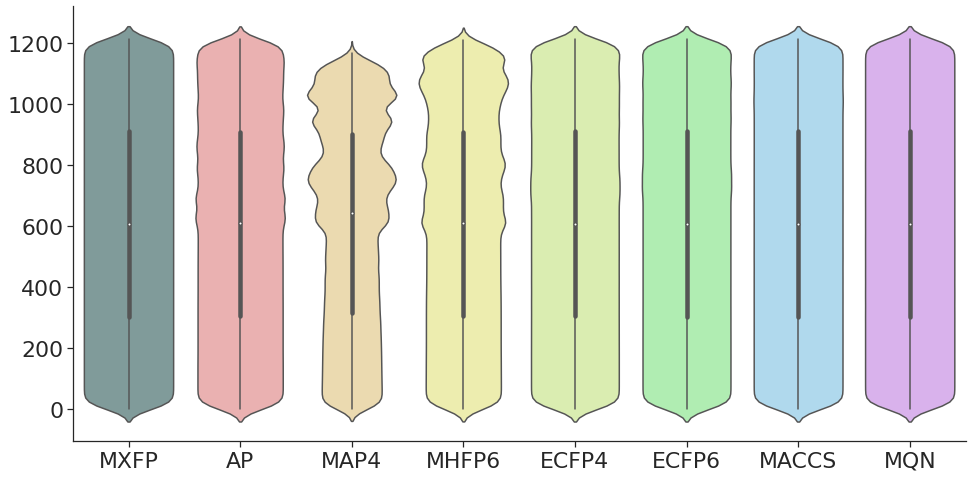

In [15]:
ax = sns.violinplot(data=df_rank_violin, scale='count', palette=sns.color_palette(['#7B9F9E', '#F4A7A7', '#F5DEA6', '#F7F7A5', '#DEF7A7', '#A6F7A8', '#A6DDF7', '#DCA8F6']))

sns.set(rc={'figure.figsize':(16, 8)})
sns.set(font_scale=2)
sns.set_style('ticks')
sns.despine()
plt.savefig('plots/fda_approved_ranking_distributions.pdf', bbox_inches='tight')

Plot heatmap of pairwise Euclidean distances between the ranks

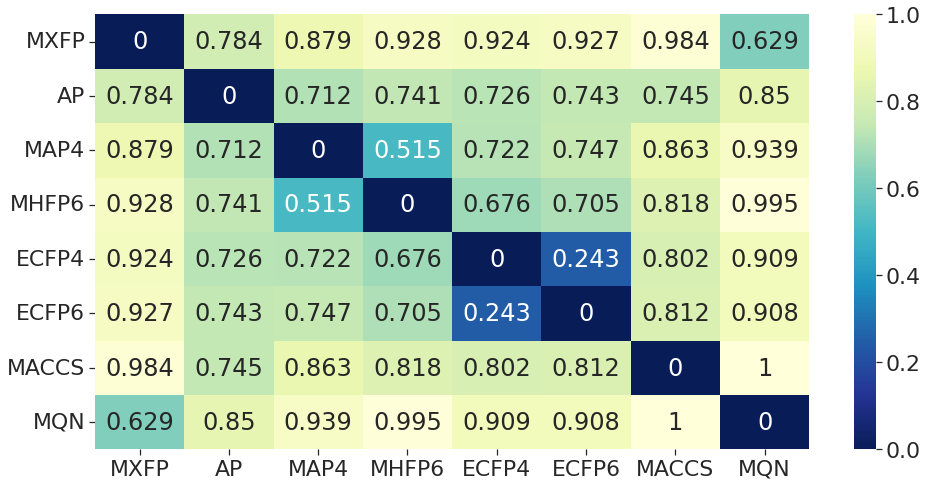

In [16]:
ranked_matrices_list = [mxfp2d_rankmat, ap_rankmat, map4_rankmat, mhfp6_rankmat, ecfp4_rankmat, ecfp6_rankmat, maccs_rankmat, mqn_rankmat]
nn_distance_matrix = np.zeros((len(ranked_matrices_list), len(ranked_matrices_list)))

for i in range(len(ranked_matrices_list)):
    for j in range(len(ranked_matrices_list)):
        nn_distance_matrix[i, j] = np.linalg.norm(ranked_matrices_list[i] - ranked_matrices_list[j])

nn_distance_matrix = MinMax(nn_distance_matrix)
pairwise_matrix = pd.DataFrame(nn_distance_matrix, 
                                columns=['MXFP', 'AP', 'MAP4', 'MHFP6', 'ECFP4', 'ECFP6', 'MACCS', 'MQN'], 
                                index=['MXFP', 'AP', 'MAP4', 'MHFP6', 'ECFP4', 'ECFP6', 'MACCS', 'MQN'])

ax = sns.heatmap(pairwise_matrix, annot=True, fmt='.3g', cmap="YlGnBu_r")
plt.savefig('plots/fda_approved_euclidean_pairwise_heatmap.pdf', bbox_inches='tight')

#### TMAP visualization

Define a function that fills a quadratic matrix of arbitrary length with empty strings

In [17]:
def EmptyStringMatrix(length):

    empty_string_matrix = []

    for i in range(length):
        empty_string_list = []
        for j in range(length):
            empty_string_list.append('')
        empty_string_matrix.append(empty_string_list)
    
    return empty_string_matrix

Define a function that generate all possible unique pairs of SMILES displayed as reaction SMILES

In [18]:
smiles_list = df.smiles.values.tolist()

def PairwiseReactionSMILES(smiles_list):

    pwrs = EmptyStringMatrix(len(smiles_list))

    for i in range(len(smiles_list)):
        for j in range(i, len(smiles_list)):
            pwrs[i][j] = f'{smiles_list[i]}>>{smiles_list[j]}'
            pwrs[j][i] = f'{smiles_list[i]}>>{smiles_list[j]}'
    
    return pwrs

reaction_smiles = PairwiseReactionSMILES(smiles_list)

Prepare pandas dataframes of distance matrices

In [19]:
mxfp2d_distance = pd.DataFrame(np.array(mxfp2d_distlist).reshape(len(mxfp2d), len(mxfp2d)).T)
ap_distance = pd.DataFrame(np.array(ap_distlist).reshape(len(ap), len(ap)).T)
map4_distance = pd.DataFrame(np.array(map4_distlist).reshape(len(map4), len(map4)).T)
mhfp6_distance = pd.DataFrame(np.array(mhfp6_distlist).reshape(len(mhfp6), len(mhfp6)).T)
ecfp4_distance = pd.DataFrame(np.array(ecfp4_distlist).reshape(len(ecfp4), len(ecfp4)).T)
ecfp6_distance = pd.DataFrame(np.array(ecfp6_distlist).reshape(len(ecfp6), len(ecfp6)).T)
maccs_distance = pd.DataFrame(np.array(maccs_distlist).reshape(len(maccs), len(maccs)).T)
mqn_distance = pd.DataFrame(np.array(mqn_distlist).reshape(len(mqn), len(mqn)).T)
pairwise_smiles = pd.DataFrame(reaction_smiles)

Calculate molecule pair properties

In [20]:
def PairwiseProperty(list_of_properties):

    pairwise_difference = np.zeros((len(list_of_properties), len(list_of_properties)))

    for i in range(len(list_of_properties)):
        for j in range(i, len(list_of_properties)):
            pairwise_difference[i, j] = (list_of_properties[i] + list_of_properties[j])/2
            pairwise_difference[j, i] = (list_of_properties[i] + list_of_properties[j])/2
    
    return pairwise_difference

In [21]:
pairwise_mw = pd.DataFrame(PairwiseProperty(df.MW.values.tolist()))
pairwise_hac = pd.DataFrame(PairwiseProperty(df.HAC.values.tolist()))
pairwise_fcsp3 = pd.DataFrame(PairwiseProperty(df.FCsp3.values.tolist()))

Generate tuple list for all of the dataframes

In [22]:
mxfp2d_tuples = (pd.concat([mxfp2d_rankmat, mxfp2d_distance, ap_distance, map4_distance, mhfp6_distance, ecfp4_distance, ecfp6_distance, maccs_distance, mqn_distance, pairwise_smiles, pairwise_mw, pairwise_hac, pairwise_fcsp3]).stack().groupby(level=[0, 1]).apply(tuple).unstack())
ap_tuples = (pd.concat([ap_rankmat, mxfp2d_distance, ap_distance, map4_distance, mhfp6_distance, ecfp4_distance, ecfp6_distance, maccs_distance, mqn_distance, pairwise_smiles, pairwise_mw, pairwise_hac, pairwise_fcsp3]).stack().groupby(level=[0, 1]).apply(tuple).unstack())
map4_tuples = (pd.concat([map4_rankmat, mxfp2d_distance, ap_distance, map4_distance, mhfp6_distance, ecfp4_distance, ecfp6_distance, maccs_distance, mqn_distance, pairwise_smiles, pairwise_mw, pairwise_hac, pairwise_fcsp3]).stack().groupby(level=[0, 1]).apply(tuple).unstack())
mhfp6_tuples = (pd.concat([mhfp6_rankmat, mxfp2d_distance, ap_distance, map4_distance, mhfp6_distance, ecfp4_distance, ecfp6_distance, maccs_distance, mqn_distance, pairwise_smiles, pairwise_mw, pairwise_hac, pairwise_fcsp3]).stack().groupby(level=[0, 1]).apply(tuple).unstack())
ecfp4_tuples = (pd.concat([ecfp4_rankmat, mxfp2d_distance, ap_distance, map4_distance, mhfp6_distance, ecfp4_distance, ecfp6_distance, maccs_distance, mqn_distance, pairwise_smiles, pairwise_mw, pairwise_hac, pairwise_fcsp3]).stack().groupby(level=[0, 1]).apply(tuple).unstack())
ecfp6_tuples = (pd.concat([ecfp6_rankmat, mxfp2d_distance, ap_distance, map4_distance, mhfp6_distance, ecfp4_distance, ecfp6_distance, maccs_distance, mqn_distance, pairwise_smiles, pairwise_mw, pairwise_hac, pairwise_fcsp3]).stack().groupby(level=[0, 1]).apply(tuple).unstack())
maccs_tuples = (pd.concat([maccs_rankmat, mxfp2d_distance, ap_distance, map4_distance, mhfp6_distance, ecfp4_distance, ecfp6_distance, maccs_distance, mqn_distance, pairwise_smiles, pairwise_mw, pairwise_hac, pairwise_fcsp3]).stack().groupby(level=[0, 1]).apply(tuple).unstack())
mqn_tuples = (pd.concat([mqn_rankmat, mxfp2d_distance, ap_distance, map4_distance, mhfp6_distance, ecfp4_distance, ecfp6_distance, maccs_distance, mqn_distance, pairwise_smiles, pairwise_mw, pairwise_hac, pairwise_fcsp3]).stack().groupby(level=[0, 1]).apply(tuple).unstack())

For each fingerprint, sort and keep only top 20 for every compound (without self pairs). Concatenate the final lists

In [23]:
mxfp2d_top20 = pd.DataFrame(np.sort(mxfp2d_tuples.values, axis=0)).iloc[1:21].to_numpy().flatten().tolist()
ap_top20 = pd.DataFrame(np.sort(ap_tuples.values, axis=0)).iloc[1:21].to_numpy().flatten().tolist()
map4_top20 = pd.DataFrame(np.sort(map4_tuples.values, axis=0)).iloc[1:21].to_numpy().flatten().tolist()
mhfp6_top20 = pd.DataFrame(np.sort(mhfp6_tuples.values, axis=0)).iloc[1:21].to_numpy().flatten().tolist()
ecfp4_top20 = pd.DataFrame(np.sort(ecfp4_tuples.values, axis=0)).iloc[1:21].to_numpy().flatten().tolist()
ecfp6_top20 = pd.DataFrame(np.sort(ecfp6_tuples.values, axis=0)).iloc[1:21].to_numpy().flatten().tolist()
maccs_top20 = pd.DataFrame(np.sort(maccs_tuples.values, axis=0)).iloc[1:21].to_numpy().flatten().tolist()
mqn_top20 = pd.DataFrame(np.sort(mqn_tuples.values, axis=0)).iloc[1:21].to_numpy().flatten().tolist()

In [24]:
def OriginFP(reaction_smiles, list_of_lists):

    fp = np.zeros(len(list_of_lists))

    for i in range(len(list_of_lists)):
        if reaction_smiles in list_of_lists[i]:
            fp[i] = 1
        else:
            fp[i] = 0
    
    return fp


def ConsensusString(origin_fp):

    fp_list = ['MXFP', 'AP', 'MAP4', 'MHFP6', 'ECFP4', 'ECFP6', 'MACCS', 'MQN']
    fp_origin = ''

    for i in range(len(origin_fp)):
        if origin_fp[i] == 1:
            fp_origin = fp_origin + fp_list[i] + '; '
    
    return fp_origin

In [25]:
mxfp_smiles = pd.DataFrame(mxfp2d_top20, columns=['Rank', 'MXFP2D_distance', 'AP_distance', 'MAP4_distance', 'MHFP6_distance', 'ECFP4_distance', 'ECFP6_distance', 'MACCS_distance', 'MQN_distance', 'ReactionSMILES', 'μMW', 'μHAC', 'μFCsp3']).ReactionSMILES.values.tolist()
ap_smiles = pd.DataFrame(ap_top20, columns=['Rank', 'MXFP2D_distance', 'AP_distance', 'MAP4_distance', 'MHFP6_distance', 'ECFP4_distance', 'ECFP6_distance', 'MACCS_distance', 'MQN_distance', 'ReactionSMILES', 'μMW', 'μHAC', 'μFCsp3']).ReactionSMILES.values.tolist()
map4_smiles = pd.DataFrame(map4_top20, columns=['Rank', 'MXFP2D_distance', 'AP_distance', 'MAP4_distance', 'MHFP6_distance', 'ECFP4_distance', 'ECFP6_distance', 'MACCS_distance', 'MQN_distance', 'ReactionSMILES', 'μMW', 'μHAC', 'μFCsp3']).ReactionSMILES.values.tolist()
mhfp_smiles = pd.DataFrame(mhfp6_top20, columns=['Rank', 'MXFP2D_distance', 'AP_distance', 'MAP4_distance', 'MHFP6_distance', 'ECFP4_distance', 'ECFP6_distance', 'MACCS_distance', 'MQN_distance', 'ReactionSMILES', 'μMW', 'μHAC', 'μFCsp3']).ReactionSMILES.values.tolist()
ecfp4_smiles = pd.DataFrame(ecfp4_top20, columns=['Rank', 'MXFP2D_distance', 'AP_distance', 'MAP4_distance', 'MHFP6_distance', 'ECFP4_distance', 'ECFP6_distance', 'MACCS_distance', 'MQN_distance', 'ReactionSMILES', 'μMW', 'μHAC', 'μFCsp3']).ReactionSMILES.values.tolist()
ecfp6_smiles = pd.DataFrame(ecfp6_top20, columns=['Rank', 'MXFP2D_distance', 'AP_distance', 'MAP4_distance', 'MHFP6_distance', 'ECFP4_distance', 'ECFP6_distance', 'MACCS_distance', 'MQN_distance', 'ReactionSMILES', 'μMW', 'μHAC', 'μFCsp3']).ReactionSMILES.values.tolist()
maccs_smiles = pd.DataFrame(maccs_top20, columns=['Rank', 'MXFP2D_distance', 'AP_distance', 'MAP4_distance', 'MHFP6_distance', 'ECFP4_distance', 'ECFP6_distance', 'MACCS_distance', 'MQN_distance', 'ReactionSMILES', 'μMW', 'μHAC', 'μFCsp3']).ReactionSMILES.values.tolist()
mqn_smiles = pd.DataFrame(mqn_top20, columns=['Rank', 'MXFP2D_distance', 'AP_distance', 'MAP4_distance', 'MHFP6_distance', 'ECFP4_distance', 'ECFP6_distance', 'MACCS_distance', 'MQN_distance', 'ReactionSMILES', 'μMW', 'μHAC', 'μFCsp3']).ReactionSMILES.values.tolist()

In [26]:
top20_flat = mxfp2d_top20 + ap_top20 + map4_top20 + mhfp6_top20 + ecfp4_top20 + ecfp6_top20 + maccs_top20 + mqn_top20
top20_list = [mxfp_smiles, ap_smiles, map4_smiles, mhfp_smiles, ecfp4_smiles, ecfp6_smiles, maccs_smiles, mqn_smiles]

In [27]:
df_tmap = pd.DataFrame(top20_flat, columns=['Rank', 'MXFP2D_distance', 'AP_distance', 'MAP4_distance', 'MHFP6_distance', 'ECFP4_distance', 'ECFP6_distance', 'MACCS_distance', 'MQN_distance', 'ReactionSMILES', 'μMW', 'μHAC', 'μFCsp3'])
df_tmap = df_tmap.drop_duplicates(subset=['ReactionSMILES'])

In [28]:
df_tmap['OriginFP'] = df_tmap.ReactionSMILES.progress_apply(lambda x: OriginFP(x, top20_list))
df_tmap['ConsensusScore'] = df_tmap.OriginFP.progress_apply(np.sum)
df_tmap['ConsensusString'] = df_tmap.OriginFP.progress_apply(ConsensusString)

100%|██████████| 65297/65297 [00:00<00:00, 502235.36it/s]


Define function for merged MinHashed fingerprints

In [29]:
def MergeMAP4(reaction_smiles):

    fp1, fp2 = reaction_smiles.split('>>')
    mol1 = Chem.MolFromSmiles(fp1)
    mol2 = Chem.MolFromSmiles(fp2)

    return MHFP6.merge(MAP4.calculate(mol1), MAP4.calculate(mol2))

Calculate merged MAP4 for all molecular pairs

In [ ]:
df_tmap['MAP4'] = df_tmap.ReactionSMILES.progress_apply(MergeMAP4)

In [30]:
rxn_smiles = df_tmap['ReactionSMILES'].values.tolist()
df_tmap['DRFP'] = DrfpEncoder.encode(rxn_smiles)

Highlight selected pairs

In [31]:
def FindSelections(smiles):
    if smiles == 'COC1=CC(C2C3=CC4=C(C=C3C(O)C3COC(=O)C23)OCO4)=CC(OC)=C1OC>>COC1=CC2=C(C3=CC=C(OC)C(=O)C=C3C(NC(C)=O)CC2)C(OC)=C1OC':
        return '1 - Podophyllotoxin >> Colchicine'
    elif smiles == 'CCCN(CCC)CCC1=CC=CC2=C1CC(=O)N2>>CCCN(CCC1=CC=CS1)C1CCC2=C(O)C=CC=C2C1':
        return '2 - Ropinirole >> Rotigotine'
    elif smiles == 'CN(C)CC=CC(=O)NC1=CC2=C(NC3=CC=C(F)C(Cl)=C3)N=CN=C2C=C1OC1CCOC1>>C=CC(=O)NC1=CC(NC2=NC=CC(C3=CN(C)C4=CC=CC=C34)=N2)=C(OC)C=C1N(C)CCN(C)C':
        return '3 - Afatinib >> Osimertinib'
    elif smiles == 'N#CC1=CC=C2NC=C(CCCCN3CCN(C4=CC=C5OC(C(N)=O)=CC5=C4)CC3)C2=C1>>O=C1CCC2=CC=C(OCCCCN3CCN(C4=CC=CC(Cl)=C4Cl)CC3)C=C2N1':
        return '4 - Vilazodone >> Aripiprazole'
    else:
        return 'Not selected'

In [32]:
df_tmap['Selection'] = df_tmap['ReactionSMILES'].apply(FindSelections)
df_tmap = df_tmap.sort_values(by='Selection', ascending=False)

Generate DRFP layout

In [33]:
import warnings
from sklearn.exceptions import DataConversionWarning
warnings.filterwarnings("ignore", category=DataConversionWarning)

drfps = df_tmap['DRFP'].values.tolist()

knn = 20

knn_search = NearestNeighbors(n_neighbors=knn, radius=1.0, algorithm='auto', leaf_size=30, metric='jaccard', p=2, metric_params=None, n_jobs=None)
knn_search.fit(np.array(drfps))

edge_list = []

for i in tqdm(range(len(drfps))):
    dists, idxs = knn_search.kneighbors(drfps[i].reshape(1, -1))
    for j in range(knn):
        edge_list.append([i, idxs[0, j], dists[0, j]])

100%|██████████| 65297/65297 [59:24<00:00, 18.32it/s] 


DRFP TMAP Pairs

In [34]:
cfg = tm.LayoutConfiguration()

cfg.node_size = 1 / 30
cfg.mmm_repeats = 2
cfg.sl_extra_scaling_steps = 5
cfg.k = 20
cfg.sl_scaling_type = tm.RelativeToAvgLength

x_, y_, s, t, gp = tm.layout_from_edge_list(len(drfps), edge_list, cfg)
tm_layout_drfp = {'x': list(x_), 'y': list(y_), 's': list(s), 't': list(t)}

In [35]:
def SphereSize(label):
    if label == 'Not selected':
        return 0.75
    else:
        return 1.25

In [36]:
df_tmap['Selection'] = df_tmap.ReactionSMILES.apply(FindSelections)
df_tmap['Size'] = df_tmap['Selection'].apply(SphereSize)
size_list = df_tmap['Size'].values.tolist()

In [37]:
from matplotlib import cm

rainbow_8 = cm.get_cmap('rainbow', 8)
tab_5 = ListedColormap(['#1C63A5', '#2B9322', '#D90016', '#FFC107', '#D0D0D0'], name="tab_5")
paired = ListedColormap(['#1C63A5', '#2B9322', '#D90016', '#562888', '#D0D0D0'], name="paired")

In [38]:
labels = []

for i, row in df_tmap.iterrows():
    labels.append(
            row["ReactionSMILES"]
            + "__"
            + f'{row["ReactionSMILES"]}'
            + "__"
            + f'{row["Selection"]}'
            + "__"
            + f'Found in: {row["ConsensusString"]}'
            + "__"
            + f'MXFP: {row["MXFP2D_distance"]}'
            + "__"
            + f'AP: {row["AP_distance"]}'
            + "__"
            + f'MAP4: {row["MAP4_distance"]}'
            + "__"
            + f'MHFP6: {row["MHFP6_distance"]}'
            + "__"
            + f'ECFP4: {row["ECFP4_distance"]}'
            + "__"
            + f'ECFP6: {row["ECFP6_distance"]}'
            + "__"
            + f'MACCS: {row["MACCS_distance"]}'
            + "__"
            + f'MQN: {row["MQN_distance"]}'
        )

In [39]:
set_labels, set_data = Faerun.create_categories(df_tmap['ConsensusScore'])
sel_labels, sel_data = Faerun.create_categories(df_tmap['Selection'])

In [40]:
f = Faerun(
    view="front", 
    coords=False,
    title="",
    clear_color='#FFFFFF',
)

f.add_scatter(
    "DRFP_TMAP",
    {
        "x": tm.VectorFloat(tm_layout_drfp['x']),
        "y": tm.VectorFloat(tm_layout_drfp['y'] ),
        "c": [
            set_data,
            sel_data,
            df_tmap.μMW.values.tolist(),
            df_tmap.μHAC.values.tolist(), 
            df_tmap.μFCsp3.values.tolist(),
            df_tmap.MXFP2D_distance.values.tolist(),
            df_tmap.AP_distance.values.tolist(),
            df_tmap.MAP4_distance.values.tolist(),
            df_tmap.MHFP6_distance.values.tolist(),
            df_tmap.ECFP4_distance.values.tolist(),
            df_tmap.ECFP6_distance.values.tolist(),
            df_tmap.MACCS_distance.values.tolist(),
            df_tmap.MQN_distance.values.tolist(),
            ], 
        "labels": labels,
    },
    shader="sphere",
    point_scale=5,
    max_point_size=20,
    legend_labels=[set_labels, sel_labels, None, None, None, None, None, None, None, None, None, None, None],
    categorical=[True, True, False, False, False, False, False, False, False, False, False, False, False],
    colormap=[rainbow_8, tab_5, 'rainbow_r', 'rainbow_r', 'rainbow_r', 'rainbow_r', 'rainbow_r', 'rainbow_r', 'rainbow_r', 'rainbow_r', 'rainbow_r', 'rainbow_r', 'rainbow_r'],
    series_title=['ConsensusScore', 'Selections', 'μMW', 'μHAC', 'μFCsp3', 'MXFP_distance', 'AP_distance', 'MAP4_distance', 'MHFP6_distance', 'ECFP4_distance', 'ECFP6_distance', 'MACCS_distance', 'MQN_distance'],
    has_legend=True,
)
f.add_tree("DRFP_TMAP_tree", {"from": tm.VectorUint(tm_layout_drfp['s']), "to": tm.VectorUint(tm_layout_drfp['t'])}, point_helper="DRFP_TMAP")
f.plot('plots/fda_approved_DRFP_TMAP', template='reaction_smiles')

/home/markus/Developer/Code/mxfp_python/benchmark/plots/fda_approved_DRFP_TMAP.html

MAP4 TMAP Pairs

In [ ]:
lf = tm.LSHForest(1024, 64)

merged_map4 = np.array(df_tmap['MAP4'])
fps = []

for i in merged_map4:
    vec = tm.VectorUint(i)
    fps.append(vec)

lf.batch_add(fps)
lf.index()

cfg = tm.LayoutConfiguration() #configuration parameters for tmap layout
cfg.node_size = 1 / 50 #size of nodes which affects the magnitude of their repelling force. Decreasing this values generally resolves overlaps in a very crowded tree
cfg.mmm_repeats = 2 #number of repeats of the per-level layout algorithm
cfg.sl_extra_scaling_steps = 5 #sets the number of repeats of the scaling
cfg.k = 20 #number of nearest neighbours used to create the k-nearest neighbour graph
cfg.sl_scaling_type = tm.RelativeToAvgLength #Defines the relative scale of the graph
x, y, s, t, _ = tm.layout_from_lsh_forest(lf, cfg)

In [ ]:
from matplotlib import cm

rainbow_8 = cm.get_cmap('rainbow', 8)

In [ ]:
labels = []

for i, row in df_tmap.iterrows():
    labels.append(
            row["ReactionSMILES"]
            + "__"
            + f'{row["ReactionSMILES"]}'
            + "__"
            + f'Found in: {row["ConsensusString"]}'
            + "__"
            + f'MXFP: {row["MXFP2D_distance"]}'
            + "__"
            + f'AP: {row["AP_distance"]}'
            + "__"
            + f'MAP4: {row["MAP4_distance"]}'
            + "__"
            + f'MHFP6: {row["MHFP6_distance"]}'
            + "__"
            + f'ECFP4: {row["ECFP4_distance"]}'
            + "__"
            + f'ECFP6: {row["ECFP6_distance"]}'
            + "__"
            + f'MACCS: {row["MACCS_distance"]}'
            + "__"
            + f'MQN: {row["MQN_distance"]}'
        )

In [ ]:
set_labels, set_data = Faerun.create_categories(df_tmap['ConsensusScore'])
sel_labels, sel_data = Faerun.create_categories(df_tmap['Selection'])

In [ ]:
f = Faerun(
    view="front", 
    coords=False,
    title="",
    clear_color='#FFFFFF',
)

f.add_scatter(
    "MAP4_TMAP",
    {
        "x": x,
        "y": y,
        "c": [
            set_data,
            sel_data,
            df_tmap.μMW.values.tolist(),
            df_tmap.μHAC.values.tolist(), 
            df_tmap.μFCsp3.values.tolist(),
            df_tmap.MXFP2D_distance.values.tolist(),
            df_tmap.AP_distance.values.tolist(),
            df_tmap.MAP4_distance.values.tolist(),
            df_tmap.MHFP6_distance.values.tolist(),
            df_tmap.ECFP4_distance.values.tolist(),
            df_tmap.ECFP6_distance.values.tolist(),
            df_tmap.MACCS_distance.values.tolist(),
            df_tmap.MQN_distance.values.tolist(),
            ],
        "labels": labels,
    },
    shader="sphere",
    point_scale=2,
    max_point_size=20,
    legend_labels=[set_labels, sel_labels, None, None, None, None, None, None, None, None, None, None, None],
    categorical=[True, True, False, False, False, False, False, False, False, False, False, False, False],
    colormap=[rainbow_8, tab_4, 'rainbow_r', 'rainbow_r', 'rainbow_r', 'rainbow_r', 'rainbow_r', 'rainbow_r', 'rainbow_r', 'rainbow_r', 'rainbow_r', 'rainbow_r', 'rainbow_r'],
    series_title=['ConsensusScore', 'Selection', 'μMW', 'μHAC', 'μFCsp3', 'MXFP_distance', 'AP_distance', 'MAP4_distance', 'MHFP6_distance', 'ECFP4_distance', 'ECFP6_distance', 'MACCS_distance', 'MQN_distance'],
    has_legend=True,
)
f.add_tree("MAP4_TMAP_tree", {"from": s, "to": t}, point_helper="MAP4_TMAP")
f.plot('plots/fda_approved_MAP4_TMAP', template='reaction_smiles')

MAP4 TMAP Molecules

In [ ]:
def FindSelections(smiles):
    if smiles == 'COC1=CC(C2C3=CC4=C(C=C3C(O)C3COC(=O)C23)OCO4)=CC(OC)=C1OC':
        return '1 - Podophyllotoxin'
    elif smiles == 'COC1=CC2=C(C3=CC=C(OC)C(=O)C=C3C(NC(C)=O)CC2)C(OC)=C1OC':
        return '2 - Colchicine'
    elif smiles == 'CCCN(CCC)CCC1=CC=CC2=C1CC(=O)N2':
        return '3 - Ropinirole'
    elif smiles == 'CCCN(CCC1=CC=CS1)C1CCC2=C(O)C=CC=C2C1':
        return '4 - Rotigotine'
    elif smiles == 'CN(C)CC=CC(=O)NC1=CC2=C(NC3=CC=C(F)C(Cl)=C3)N=CN=C2C=C1OC1CCOC1':
        return '5 - Afatinib'
    elif smiles == 'C=CC(=O)NC1=CC(NC2=NC=CC(C3=CN(C)C4=CC=CC=C34)=N2)=C(OC)C=C1N(C)CCN(C)C':
        return '6 - Osimertinib'
    elif smiles == 'N#CC1=CC=C2NC=C(CCCCN3CCN(C4=CC=C5OC(C(N)=O)=CC5=C4)CC3)C2=C1':
        return '7 - Vilazodone'
    elif smiles == 'O=C1CCC2=CC=C(OCCCCN3CCN(C4=CC=CC(Cl)=C4Cl)CC3)C=C2N1':
        return '8 - Aripiprazole'
    else:
        return 'Not selected'

def SphereSize(set_label):
    if set_label == 'Not selected':
        return 0.75
    else:
        return 1.5

In [ ]:
df['Selection'] = df.smiles.apply(FindSelections)
df['Size'] = df.Selection.apply(SphereSize)

df = df.sort_values(by='Selection', ascending=False)

selection_labels, selection_data = Faerun.create_categories(df['Selection'])
size_list = df['Size'].values.tolist()

In [ ]:
lf = tm.LSHForest(1024, 64)

merged_map4 = np.array(df['MAP4'])
fps = []

for i in merged_map4:
    vec = tm.VectorUint(i)
    fps.append(vec)

lf.batch_add(fps)
lf.index()

cfg = tm.LayoutConfiguration() #configuration parameters for tmap layout
cfg.node_size = 1 / 30 #size of nodes which affects the magnitude of their repelling force. Decreasing this values generally resolves overlaps in a very crowded tree
cfg.mmm_repeats = 2 #number of repeats of the per-level layout algorithm
cfg.sl_extra_scaling_steps = 5 #sets the number of repeats of the scaling
cfg.k = 15 #number of nearest neighbours used to create the k-nearest neighbour graph
cfg.sl_scaling_type = tm.RelativeToAvgLength #Defines the relative scale of the graph
x, y, s, t, _ = tm.layout_from_lsh_forest(lf, cfg)

In [ ]:
paired = ListedColormap(['#96C3DC', '#1C63A5', '#A4DB77', '#2B9322', '#F78588', '#D90016', '#BEA1CC', '#562888', '#D0D0D0'], name="paired")
paired_8 = ListedColormap(['#96C3DC', '#1C63A5', '#A4DB77', '#2B9322', '#F78588', '#D90016', '#FFC107', '#FFDD76', '#D0D0D0'], name="paired")

In [ ]:
labels = []

for i, row in df.iterrows():
    labels.append(
            row["smiles"]
            + "__"
            + f'{row["Selection"]}'
            + "__"
            + f'{row["smiles"]}'
        )

In [ ]:
f = Faerun(
    view="front", 
    coords=False,
    title="",
    clear_color='#FFFFFF',
)

f.add_scatter(
    "MAP4_TMAP",
    {
        "x": x,
        "y": y,
        "c": [
            df.MW.values.tolist(),
            df.HAC.values.tolist(), 
            df.FCsp3.values.tolist(),
            selection_data
            ],
        "s": [size_list, 
            size_list,
            size_list,
            size_list,
            ],
        "labels": labels,
    },
    shader="sphere",
    point_scale=8,
    max_point_size=20,
    legend_labels=[None, None, None, selection_labels],
    categorical=[False, False, False, True],
    colormap=['rainbow_r', 'rainbow_r', 'rainbow_r', paired_8],
    series_title=['μMW', 'μHAC', 'μFCsp3', 'Selection'],
    has_legend=True,
)
f.add_tree("MAP4_TMAP_tree", {"from": s, "to": t}, point_helper="MAP4_TMAP")
f.plot('plots/fda_approved_mols_MAP4_TMAP', template='smiles')

Calculate ECFP4 Tanimoto distance of selected pairs

In [ ]:
selection_smiles = [
                    'COC1=CC(C2C3=CC4=C(C=C3C(O)C3COC(=O)C23)OCO4)=CC(OC)=C1OC', 
                    'COC1=CC2=C(C3=CC=C(OC)C(=O)C=C3C(NC(C)=O)CC2)C(OC)=C1OC', 
                    'CCCN(CCC)CCC1=CC=CC2=C1CC(=O)N2', 
                    'CCCN(CCC1=CC=CS1)C1CCC2=C(O)C=CC=C2C1', 
                    'CN(C)CC=CC(=O)NC1=CC2=C(NC3=CC=C(F)C(Cl)=C3)N=CN=C2C=C1OC1CCOC1', 
                    'C=CC(=O)NC1=CC(NC2=NC=CC(C3=CN(C)C4=CC=CC=C34)=N2)=C(OC)C=C1N(C)CCN(C)C', 
                    'N#CC1=CC=C2NC=C(CCCCN3CCN(C4=CC=C5OC(C(N)=O)=CC5=C4)CC3)C2=C1', 
                    'O=C1CCC2=CC=C(OCCCCN3CCN(C4=CC=CC(Cl)=C4Cl)CC3)C=C2N1'
                    ]

selection_mols = [Chem.MolFromSmiles(smiles) for smiles in selection_smiles]
selection_fps = [AllChem.GetMorganFingerprintAsBitVect(mol, 2) for mol in selection_mols]
selection_sims = [DataStructs.FingerprintSimilarity(selection_fps[i], selection_fps[i+1]) for i in range(0, 7, 2)]
selection_sims